## 🔒 LABOR MARKET TIGHTNESS

**Indicators:**

| Indicator                  | Source              | Notes                                                             |
| -------------------------- | ------------------- | ----------------------------------------------------------------- |
| Job Openings Rate          | JOLTS (`JTSJOL`)    | Total Nonfarm or by industry                                      |
| Hires Rate                 | JOLTS (`JTSHIR`)    | Hiring flow                                                       |
| Beveridge Ratio            | Derived             | = Job Openings / Unemployed                                       |
| Openings per Hire          | Derived             | = Job Openings / Hires                                            |
| **Prime-Age LFPR (25–54)** | BLS (`LNS11300060`) | Best signal of active labor force engagement, avoids demographics |

**Feature Engineering Ideas:**

* `OpeningsPerUnemployed = Job Openings / Unemployed`
* `OpeningsPerHire = Job Openings / Hires`
* `PrimeLFPR_Zscore = z-score(LNS11300060)`
* `ParticipationGap = Pre-pandemic Prime LFPR – Current Prime LFPR`
* Normalize tightness indicators using z-scores or rolling trends


In [117]:
import pandas as pd

LMT_df= pd.read_excel('Data/Labor_Market_Tightness.xlsx')

# FEATURE ENGINEERING

## Calculate the Openings_Per_Unemployed
LMT_df["Openings_Per_Unemployed"]= LMT_df['Job_Openings_Rate']/LMT_df['Unemployment_Level']

## Calculate the Openings_Per_Hire
LMT_df["Openings_Per_Hire"]= LMT_df['Job_Openings_Rate']/LMT_df['Hires_Rate']

## Calculate the PrimeLFPR Z-Score
LMT_df["PrimeLFPR_Zscore"]= (LMT_df['Prime_Age_Labor_Force_Participation_Rate'] - LMT_df['Prime_Age_Labor_Force_Participation_Rate'].mean()) / LMT_df['Prime_Age_Labor_Force_Participation_Rate'].std()

## Calculate the ParticipationGap

baseline = LMT_df[(LMT_df['observation_date'] >= '2015-01-01') & (LMT_df['observation_date'] <= '2019-12-01')]['Prime_Age_Labor_Force_Participation_Rate'].mean()

LMT_df['ParticipationGap'] = baseline - LMT_df['Prime_Age_Labor_Force_Participation_Rate']



### Labor Market Tightness Index
**Purpose:** Measures the ease of hiring and labor demand-supply conditions.

| Range       | Label            | Interpretation                    |
| ----------- | ---------------- | --------------------------------- |
| ≤ -0.5      | **Slack Market** | Few openings, low hiring          |
| -0.5 to 0.5 | **Moderate**     | Balanced labor supply-demand      |
| 0.5 to 1.5  | **Tight**        | Firms competing for workers       |
| > 1.5       | **Overheated**   | Extreme tightness, inflation risk |

<Axes: >

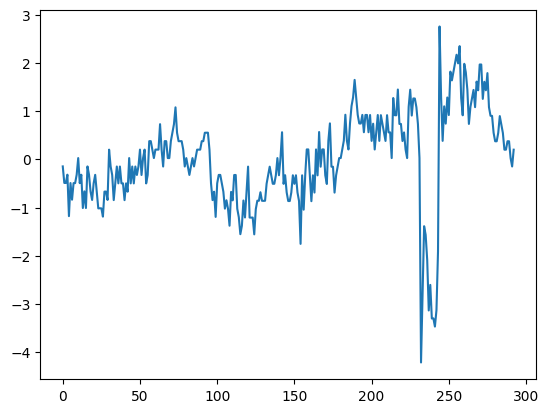

In [118]:
from scipy.stats import zscore

tightness_vars = [
    'Job_Openings_Rate',
    'Hires_Rate',
    'Openings_Per_Unemployed',  # Derived
    'Openings_Per_Hire',        # Derived
    'PrimeLFPR_Zscore'        # Z-scored
    
]

# Normalize via Z-score and average
LMT_df['Labor_Tightness_Index'] = LMT_df[tightness_vars].apply(zscore).mean(axis=1)


LMT_df['Freeze_Label'] = pd.qcut(
    LMT_df['Labor_Tightness_Index'], 
    q=4, 
    labels=['Slack_Market', 'Moderate', 'Tight', 'Overheated']
)

LMT_df['Labor_Tightness_Index'].plot()

In [119]:
LMT_df

,observation_date,Job_Openings_Rate,Hires_Rate,Prime_Age_Labor_Force_Participation_Rate,Unemployment_Level,Openings_Per_Unemployed,Openings_Per_Hire,PrimeLFPR_Zscore,ParticipationGap,Labor_Tightness_Index,Freeze_Label
0,2000-12-01,5088.0,5426.0,-0.11905,5634,0.903088,0.937707,-0.144961,0.507885,-0.145209,Moderate
1,2001-01-01,5234.0,5722.0,-0.35545,6023,0.869002,0.914715,-0.488144,0.744285,-0.488980,Moderate
2,2001-02-01,5097.0,5303.0,-0.35545,6089,0.837083,0.961154,-0.488144,0.744285,-0.488980,Moderate
3,2001-03-01,4762.0,5528.0,-0.23725,6141,0.775444,0.861433,-0.316553,0.626085,-0.317095,Moderate
4,2001-04-01,4615.0,5204.0,-0.82938,6271,0.735927,0.886818,-1.176151,1.218215,-1.178163,Slack_Market
...,...,...,...,...,...,...,...,...,...,...,...
288,2024-12-01,7508.0,5374.0,0.24038,6886,1.090328,1.397097,0.376825,0.148455,0.377470,Tight
289,2025-01-01,7762.0,5371.0,0.24010,6849,1.133304,1.445168,0.376418,0.148735,0.377062,Tight
290,2025-02-01,7480.0,5370.0,0.00000,7052,1.060692,1.392924,0.027864,0.388835,0.027912,Moderate
291,2025-03-01,7192.0,5411.0,-0.11990,7083,1.015389,1.329144,-0.146195,0.508735,-0.146445,Moderate


## 😣 LABOR MARKET DISTRESS

**Indicators:**

| Indicator                 | Source              | Notes                                        |
| ------------------------- | ------------------- | -------------------------------------------- |
| Unemployment Rate (U-3)   | BLS (`UNRATE`)      | Official unemployment rate                   |
| **U-6 Unemployment Rate** | BLS (`U6RATE`)      | Includes underemployed & discouraged workers |
| Initial Jobless Claims    | FRED (`ICSA`)       | Weekly job loss inflow                       |
| Continued Jobless Claims  | FRED (`CCSA`)       | Persistent unemployment inflow               |
| Median Weeks Unemployed   | BLS (`LNS13008275`) | Duration signal of unemployment hardship     |
| Long-term Unemployed (%)  | Derived             | = UEMP27OV / UNEMPLOY                        |

**Feature Engineering Ideas:**

* `Unemployed27Share = UEMP27OV / UNEMPLOY`
* `Lagged_Claims = Rolling average of ICSA over 4–8 weeks`
* `MedianWeeks_Zscore`
* `U6_U3_Spread = U6RATE - UNRATE` (hidden slack signal)
* Combine into a `DistressIndex` using PCA or averaging

In [120]:
import pandas as pd

LMD_df= pd.read_excel('Data/Labor_Market_Distress.xlsx')

# FEATURE ENGINEERING

## Calculate the Long-Term Unemployed (%)
LMD_df["%_Long_Term_Unemployed"]= LMD_df['Unemployed_27_Weeks_More']/LMD_df['Unemployment_Level']

## Calculate the Lagged_Claims (Rolling average of ICSA over 4-8 Weeks)
Lagged_Claims_4m = LMD_df['Initial_Jobless_Claims'].rolling(window=4).mean()
Lagged_Claims_8m = LMD_df['Initial_Jobless_Claims'].rolling(window=8).mean()

LMD_df['Lagged_Claims_Average'] = (Lagged_Claims_4m + Lagged_Claims_8m) / 2

## Calculate Median Weeks Z-Score
LMD_df["MedianWeeks_Zscore"]= (LMD_df['Median_Weeks_Unemployed'] - LMD_df['Median_Weeks_Unemployed'].mean()) / LMD_df['Median_Weeks_Unemployed'].std()

## Calculate U6_U3_Spread (hidden slack signal)
LMD_df["U6_U3_Spread"]=  LMD_df['%_U6_Unemployment_Rate'] - LMD_df['%_U3_Unemployment_Rate']



### Labor Market Stress Index
**Purpose:** Captures distress signals like unemployment, jobless claims, and long-term joblessness.

| Range | Label               | Interpretation                       |
| ------------------------- | ------------------- | ------------------------------------ |
| ≤ -0.5                    | **Satisifed**          | Low unemployment, low claims         |
| -0.5 to 0.5               | **Neutral**         | Typical or average stress levels     |
| 0.5 to 1.5                | **Stressing_Out** | Early warning signs                  |
| > 1.5                     | **Deppression** | Crisis-level unemployment or layoffs |

<Axes: >

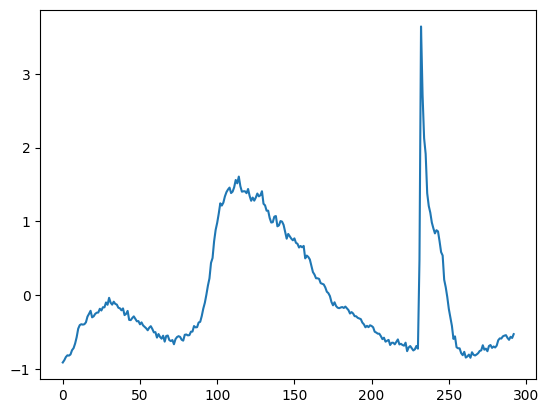

In [121]:
stress_vars = [
    '%_U3_Unemployment_Rate',
    'U6_U3_Spread',
    'Initial_Jobless_Claims',
    'Continued_Jobless_Claims',
    'Median_Weeks_Unemployed',
    '%_Long_Term_Unemployed'
]

LMD_df['Labor_Stress_Index'] = LMD_df[stress_vars].apply(zscore).mean(axis=1)


LMD_df['Stress_Label'] = pd.qcut(
    LMD_df['Labor_Stress_Index'], 
    q=4, 
    labels=['Satisfied', 'Neutral', 'Stressing_Out', 'Deppression']
)

LMD_df['Labor_Stress_Index'].plot()

## 🔁 LABOR MOBILITY / CONFIDENCE

**Indicators:**

| Indicator              | Source           | Notes                                                                           |
| ---------------------- | ---------------- | ------------------------------------------------------------------------------- |
| Quit Rate              | JOLTS (`JTSQUR`) | Lower values suggest fear of switching jobs                                     |
| Quits-to-Layoffs Ratio | Derived          | = Quits / Layoffs; higher ratio means confidence in job switching               |
| Layoffs and Discharges | JOLTS (`JTSLDL`) | Involuntary exits — higher values may signal a weakening labor market           |
| **Total Separations**  | JOLTS (`JTSTSL`) | Total worker exits (voluntary + involuntary); helps contextualize flow dynamics |

**Feature Engineering Ideas:**

* `QuitsToLayoffs = Quits / Layoffs`
* `VoluntaryShare = Quits / Total Separations` (confidence indicator)
* `LayoffShock = % change in Layoffs MoM`
* `SeparationFlow_z = z-score(Total Separations)` (to detect surges or freezes)
* Normalize metrics using rolling z-scores or trend slopes

In [122]:
import pandas as pd

LCM_df = pd.read_excel('Data/Labor_Confidence_and_Mobility.xlsx')

# FEATURE ENGINEERING

## Calculate the Quits-to-Layoff_Ratio
LCM_df['Quits_to_Layoffs']= LCM_df['Quits_Rate']/LCM_df['Layoffs_and_Discharges']

## Calculate the Voluntary-to-Quit_Ratio
LCM_df['Voluntary_to_Quits']= LCM_df['Quits_Rate']/LCM_df['Total_Seperations']

## Calculate the LayoffShock
LCM_df['LayoffShock']= LCM_df['Layoffs_and_Discharges'].pct_change() * 100

## Calculate Seperation Flow Z-Score
LCM_df["SeperationFlow_Zscore"]= (LCM_df['Total_Seperations'] - LCM_df['Total_Seperations'].mean()) / LCM_df['Total_Seperations'].std()




### Mobility & Voluntariness Index
**Purpose:** Reflects worker confidence via quitting behavior, layoffs, and voluntary exits.

| Range       | Label                | Interpretation                        |
| ----------- | -------------------- | ------------------------------------- |
| ≤ -0.5      | **Frozen Mobility**  | Low quits, high layoffs               |
| -0.5 to 0.5 | **Cautious**         | Workers hesitant to switch            |
| 0.5 to 1.5  | **Healthy Mobility** | Good churn, voluntary exits           |
| > 1.5       | **High Confidence**  | Peak labor confidence, rapid movement |


<Axes: >

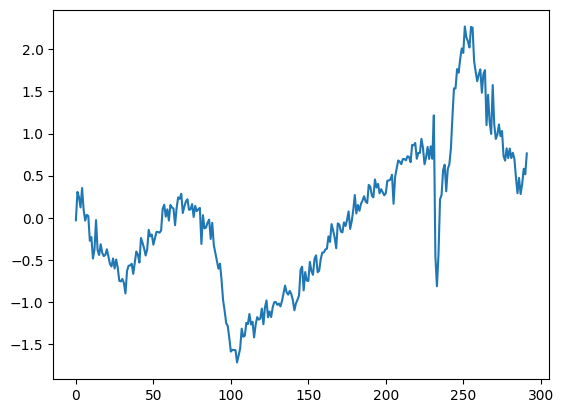

In [131]:
mobility_vars = [
    'Quits_Rate',
    'Quits_to_Layoffs',
    'Voluntary_to_Quits',
    'LayoffShock',
    'SeperationFlow_Zscore'
]

LCM_df['Labor_Mobility_Index'] = LCM_df[mobility_vars].apply(zscore).mean(axis=1)


LCM_df['Mobility_Label'] = pd.qcut(
    LCM_df['Labor_Mobility_Index'], 
    q=4, 
    labels=['Stuck', 'Cautious', 'Active', 'High_Confidence']
)

LCM_df['Labor_Mobility_Index'].plot()


## 💸 COMPENSATION & PARTICIPATION SIGNALS

**Indicators:**

| Indicator                                | Source                          | Notes                                                             |
| ---------------------------------------- | ------------------------------- | ----------------------------------------------------------------- |
| Avg Weekly Earnings – Total Private      | CES (`CES0500000030`)           | Nominal wages for majority of workforce                           |
| Median Hourly Wage Growth – 3MMA         | FRB ATL (`FRBATLWGT3MMAUMHWGO`) | Real-time, outlier-resistant wage pressure indicator              |
| Prime-Age Employment-to-Population Ratio | BLS (`LNS12300060`)             | Measures active employment engagement for 25–54 y/o               |
| Prime-Age Labor Force Participation Rate | BLS (`LNS11300060`)             | Best signal of core labor market participation                    |
| CPI Inflation (YoY % Change)             | FRED (`CPIAUCSL`)               | Used to deflate wages for purchasing power                        |
| Avg Weekly Hours – Total Private         | CES (`AWHAETP`)                 | Gauges workload; leading indicator for hours-based hiring freezes |

**Feature Engineering Ideas:**

* `AWE_YoY = AWE.pct_change(periods=12) * 100`
* `RealWageGrowth = AWE_YoY - CPI_YoY`
* `WageGrowth_YoY = AWE_YoY`
* `MedianWage3MMA_Z = z-score(FRBATL_Wage3MMA)`
* `PrimeAgeEPOP_Zscore`
* `PrimeLFPR_Trend = Current – 12-month lag`
* `WeeklyHours_Trend = Δ AWHAETP over 12 months`
* Include wage and hour trends in a `CompensationPressureIndex`

In [124]:
CPS_df = pd.read_excel('Data/Compensation_and_Participation_Signal.xlsx')
# FEATURE ENGINEERING

## Calculate Average_Weekly_Earning Year-to-Year
CPS_df['AWE_YoY'] = CPS_df['Average_Weekly_Earnings'].pct_change(periods=12) * 100

## Calculate RealWageGrowth
CPI_YoY = CPS_df['Consumer_Price_Index'].pct_change(periods=12) * 100
CPS_df['RealWageGrowth'] = CPS_df['AWE_YoY'] - CPI_YoY

## Calculate PrimeAgeEPOP Z-score
CPS_df["PrimeAgeEPOP_z"]= (CPS_df['Prime_Age_Employment_to_Population_Ratio'] - CPS_df['Prime_Age_Employment_to_Population_Ratio'].mean()) / CPS_df['Prime_Age_Employment_to_Population_Ratio'].std()

## Calculate MedianWage3MMA Z-score
CPS_df["MedianWage3MMA_z"]= (CPS_df['Median_Hourly_Wage_Growth_3MMA'] - CPS_df['Median_Hourly_Wage_Growth_3MMA'].mean()) / CPS_df['Median_Hourly_Wage_Growth_3MMA'].std()


## Calculate PrimeLFPR_Trend
CPS_df["PrimeLFPR_Trend"]= CPS_df['Prime_Age_Labor_Force_Participation_Rate'] - CPS_df['Prime_Age_Labor_Force_Participation_Rate'].shift(12)


## Calculate WeeklyHours_Trend
CPS_df['WeeklyHours_Trend'] = CPS_df['Average_Weekly_Hours'] - CPS_df['Average_Weekly_Hours'].shift(12)



### Compensation Pressure Index
**Purpose:** Signals wage growth vs inflation pressure, workload trends, and wage competitiveness.

💸 3. Compensation Pressure Index
| Label                   | Description                                                 |
| ----------------------- | ----------------------------------------------------------- |
| **Stagnated**     | Weak or negative wage growth, low hours                     |
| **Stable** | Normal wage and hour trends                                 |
| **Elevated_Push**   | Rising wages or working hours; early signs of cost stress   |
| **Strong_Push**  | Strong wage growth and/or inflation-driven pay acceleration |


<Axes: >

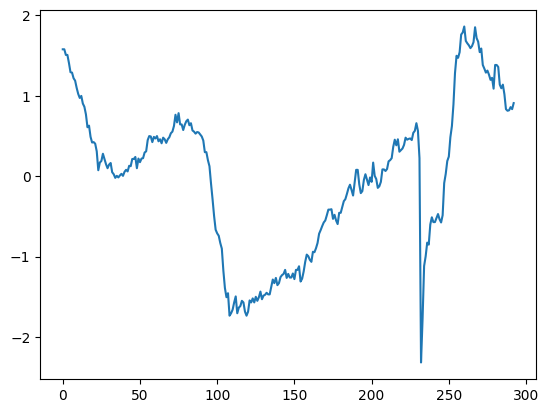

In [125]:
comp_vars = [
    'AWE_YoY',
    'RealWageGrowth',
    'MedianWage3MMA_z',
    'PrimeAgeEPOP_z',
    'WeeklyHours_Trend'
]

CPS_df['Labor_Compensation_Pressure_Index'] = CPS_df[comp_vars].apply(zscore).mean(axis=1)
CPS_df


CPS_df['Pressure_Label'] = pd.qcut(
    CPS_df['Labor_Compensation_Pressure_Index'], 
    q=4, 
    labels=['Stagnated', 'Stable', 'Elevated_Push', 'Strong_Push']
)
CPS_df['Labor_Compensation_Pressure_Index'].plot()

In [126]:
CPS_df

,observation_date,Average_Weekly_Earnings,Prime_Age_Employment_to_Population_Ratio,Consumer_Price_Index,Prime_Age_Labor_Force_Participation_Rate,Average_Weekly_Hours,Median_Hourly_Wage_Growth_3MMA,AWE_YoY,RealWageGrowth,PrimeAgeEPOP_z,MedianWage3MMA_z,PrimeLFPR_Trend,WeeklyHours_Trend,Labor_Compensation_Pressure_Index,Pressure_Label
0,2000-12-01,485.86,81.4,174.600,-0.11905,NaN,5.4,NaN,NaN,1.557256,1.594719,NaN,NaN,1.578684,Strong_Push
1,2001-01-01,488.72,81.4,175.600,-0.35545,NaN,5.4,NaN,NaN,1.557256,1.594719,NaN,NaN,1.578684,Strong_Push
2,2001-02-01,488.24,81.3,176.000,-0.35545,NaN,5.3,NaN,NaN,1.507319,1.505035,NaN,NaN,1.508754,Strong_Push
3,2001-03-01,491.72,81.3,176.100,-0.23725,NaN,5.3,NaN,NaN,1.507319,1.505035,NaN,NaN,1.508754,Strong_Push
4,2001-04-01,490.96,80.9,176.400,-0.82938,NaN,5.3,NaN,NaN,1.307570,1.505035,NaN,NaN,1.408709,Strong_Push
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2024-12-01,1033.58,80.5,317.603,0.24038,34.2,4.2,3.729351,0.856985,1.107821,0.518513,-0.48601,-0.2,0.814559,Strong_Push
289,2025-01-01,1034.88,80.7,319.086,0.24010,34.1,4.1,4.328891,1.329478,1.207696,0.428829,-0.36376,-0.1,0.819663,Strong_Push
290,2025-02-01,1038.58,80.5,319.775,0.00000,34.2,4.3,3.870464,1.056194,1.107821,0.608197,-0.60241,-0.1,0.859477,Strong_Push
291,2025-03-01,1046.45,80.4,319.615,-0.11990,34.3,4.3,3.892816,1.487231,1.057884,0.608197,-0.48091,-0.1,0.834466,Strong_Push


### Combine the indicies

In [127]:
import pandas as pd
import sqlite3


conn = sqlite3.connect(':memory:')

LMT_df.to_sql('Labor_Tightness_Index', conn, index=False, if_exists='replace')
LMD_df.to_sql('Labor_Stress_Index', conn, index=False, if_exists='replace')
LCM_df.to_sql('Labor_Mobility_Index', conn, index=False, if_exists='replace')
CPS_df.to_sql('Labor_Compensation_Pressure_Index', conn, index=False, if_exists='replace')


# ---------------------------
# 📊 SQL Query to Join Tables
# ---------------------------
sql_query = """
SELECT Labor_Tightness_Index.observation_date, Labor_Tightness_Index, Labor_Stress_Index, Labor_Mobility_Index, Labor_Compensation_Pressure_Index
FROM Labor_Tightness_Index
LEFT JOIN Labor_Stress_Index ON Labor_Tightness_Index.observation_date = Labor_Stress_Index.observation_date
LEFT JOIN Labor_Mobility_Index ON Labor_Tightness_Index.observation_date = Labor_Mobility_Index.observation_date
LEFT JOIN Labor_Compensation_Pressure_Index ON Labor_Compensation_Pressure_Index.observation_date = Labor_Mobility_Index.observation_date

"""

# Execute the query and load results into a DataFrame
All_Indicies_df = pd.read_sql_query(sql_query, conn)


# Close the connection
conn.close()

# Output the final DataFrame
All_Indicies_df.columns

Index(['observation_date', 'Labor_Tightness_Index', 'Labor_Stress_Index',
       'Labor_Mobility_Index', 'Labor_Compensation_Pressure_Index'],
      dtype='object')

## 🔄 **What the Frozen Market Index Represents**

It captures the *composite health or dysfunction* of the labor market by balancing:

* **Tightness** (demand strength),
* **Stress** (distress/insecurity),
* **Compensation Pressure** (wage/hours signals),
* **Mobility** (worker confidence in switching).


#### 1. **Normalize all sub-indices (Z-score or MinMax)**

If they’re already z-scored, you can average them directly. Otherwise:

In [128]:
from sklearn.preprocessing import StandardScaler

# Step 2: Normalize all sub-indices
index_cols = [
    'Labor_Tightness_Index',
    'Labor_Stress_Index',
    'Labor_Mobility_Index',
    'Labor_Compensation_Pressure_Index'
]

scaler = StandardScaler()
All_Indicies_df[index_cols] = scaler.fit_transform(All_Indicies_df[index_cols])


# Step 3: Invert positive signals (Tightness & Mobility reflect strength, not weakness)
All_Indicies_df['Frozen_Market_Index'] = (
    -All_Indicies_df['Labor_Tightness_Index'] +        # Invert tightness (strong = less frozen)
     All_Indicies_df['Labor_Stress_Index'] +           # Stress (more = more frozen)
     All_Indicies_df['Labor_Compensation_Pressure_Index'] +  # High compensation pressure may indicate wage stickiness / freeze
    -All_Indicies_df['Labor_Mobility_Index']           # Invert mobility (confident market = less frozen)
) / 4

# Step 4 (Optional): Add a smoothed version
All_Indicies_df['Frozen_Market_Index_Smoothed'] = (
    All_Indicies_df['Frozen_Market_Index']
    .rolling(window=3, center=True)
    .mean()
)

#### **Label the Frozen_Market_Index into 4 classes:**
🔵 Loose Market – Healthy, dynamic labor conditions

🟡 Balanced – Neutral or stable

🟠 Mild Freeze – Signs of stress emerging

🔴 Severe Freeze – Major labor market dysfunction

In [129]:
All_Indicies_df['Freeze_Label'] = pd.qcut(
    All_Indicies_df['Frozen_Market_Index'], 
    q=4, 
    labels=['Loose', 'Balanced', 'Mild Freeze', 'Severe Freeze']
)

All_Indicies_df

,observation_date,Labor_Tightness_Index,Labor_Stress_Index,Labor_Mobility_Index,Labor_Compensation_Pressure_Index,Frozen_Market_Index,Frozen_Market_Index_Smoothed,Freeze_Label
0,2000-12-01 00:00:00,-0.145209,-1.179122,-0.035075,1.678149,0.169828,NaN,Mild Freeze
1,2001-01-01 00:00:00,-0.488980,-1.139029,0.361909,1.678149,0.166548,0.172275,Mild Freeze
2,2001-02-01 00:00:00,-0.488980,-1.083969,0.287167,1.603959,0.180451,0.175894,Mild Freeze
3,2001-03-01 00:00:00,-0.317095,-1.053814,0.144509,1.603959,0.180683,0.220383,Mild Freeze
4,2001-04-01 00:00:00,-1.178163,-1.059248,0.416676,1.497820,0.300015,0.220113,Mild Freeze
...,...,...,...,...,...,...,...,...
288,2024-12-01 00:00:00,0.377470,-0.748949,0.469492,0.867479,-0.182108,-0.170665,Balanced
289,2025-01-01 00:00:00,0.377062,-0.782440,0.685995,0.872894,-0.243151,-0.179277,Balanced
290,2025-02-01 00:00:00,0.027912,-0.729297,0.608211,0.915134,-0.112571,-0.169997,Balanced
291,2025-03-01 00:00:00,-0.146445,-0.750619,0.901500,0.888599,-0.154269,NaN,Balanced


ConversionError: Failed to convert value(s) to axis units: [Timestamp('2001-03-01 00:00:00'), Timestamp('2001-11-01 00:00:00')]

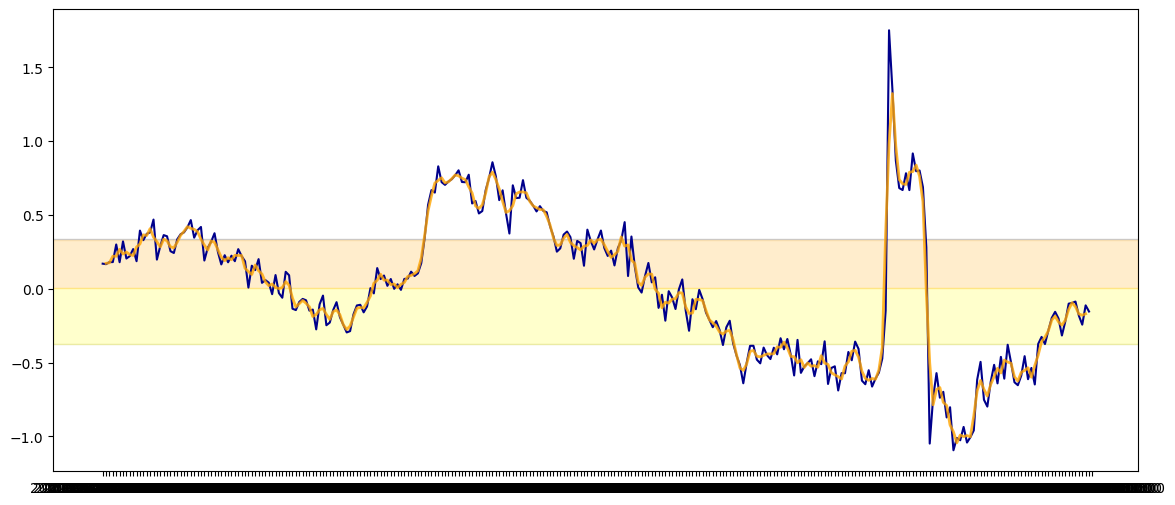

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# Define label to Y-range mapping based on actual label content
label_y_ranges = {
    'Loose': (-np.inf, All_Indicies_df.loc[All_Indicies_df['Freeze_Label'] == 'Loose', 'Frozen_Market_Index'].max()),
    'Balanced': (
        All_Indicies_df.loc[All_Indicies_df['Freeze_Label'] == 'Balanced', 'Frozen_Market_Index'].min(),
        All_Indicies_df.loc[All_Indicies_df['Freeze_Label'] == 'Balanced', 'Frozen_Market_Index'].max()
    ),
    'Mild Freeze': (
        All_Indicies_df.loc[All_Indicies_df['Freeze_Label'] == 'Mild Freeze', 'Frozen_Market_Index'].min(),
        All_Indicies_df.loc[All_Indicies_df['Freeze_Label'] == 'Mild Freeze', 'Frozen_Market_Index'].max()
    ),
    'Severe Freeze': (
        All_Indicies_df.loc[All_Indicies_df['Freeze_Label'] == 'Severe Freeze', 'Frozen_Market_Index'].min(),
        np.inf
    )
}

# Recession periods
recessions = [
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-04-01')
]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Shade Y ranges based on labels
colors = {
    'Loose': 'grey',
    'Balanced': 'yellow',
    'Mild Freeze': 'orange',
    'Severe Freeze': 'black'
}

for label, (ymin, ymax) in label_y_ranges.items():
    ax.axhspan(ymin, ymax, color=colors[label], alpha=0.2, label=label)

# Plot lines
ax.plot(All_Indicies_df['observation_date'], All_Indicies_df['Frozen_Market_Index'], label='Frozen Market Index', color='darkblue')
ax.plot(All_Indicies_df['observation_date'], All_Indicies_df['Frozen_Market_Index_Smoothed'], label='Smoothed', color='orange', linewidth=2, alpha=0.8)

# Shade recession periods
for start, end in recessions:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.3)

# Final touches
ax.set_title('Frozen Labor Market Index with Recession and Freeze Severity Bands')
ax.set_xlabel('Date')
ax.set_ylabel('Index Value')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.legend(loc='upper right')
ax.grid(True)

plt.tight_layout()
plt.show()

